# Python Project : Delta Hedging of a Multi-Asset Portfolio

**Author:** Baptiste Sorel  
**Date:** September 2025  

---

## Project Description

This project aims to implement and analyze **pricing** and **risk management** techniques for options on multiple assets.  

We consider a portfolio with the following positions:

- Short **1 MSFT call**
- Long **3 MSFT puts**
- Short **2 AAPL calls**

The hedge is rebalanced on a daily basis in the first part of the project.  
For simplicity, we assume **no transaction costs or taxes**. 

### Main Objectives
- Compute **implied volatilities** using an interpolation method.  
- Implement the **Black–Scholes framework** for call and put options.  
- Compute **$\Delta$** and analyze its role in portfolio hedging.  
- Simulate correlated asset price paths using **Geometric Brownian Motion**.  
- Compare the performance of a **delta-hedged portfolio** versus an **unhedged one**.  
- Run **Monte Carlo simulations** to evaluate the efficiency of hedging strategies.  
- Compare the performance of delta-hedged portfolios under different **rebalancing frequencies**.  

### Assumptions
$K_{MSFT}=\$500
\\ K_{AAPL}=\$230 
\\ T=1
\\ r=4\% \text{    (assumed constant)}
\\ q_{MSFT}=0.66\%    \text{   (annual dividend yield)}
\\ q_{AAPL} = 0.44\%    \text{   (annual dividend yield)}$

Importing libraries :

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
from datetime import datetime
from scipy.interpolate import interp1d 
from scipy.optimize import newton

Import one year of data for MSFT and AAPL stocks

In [120]:
msft = yf.download("MSFT", start="2024-09-12", end="2025-09-13")
aapl= yf.download("AAPL", start="2024-09-12", end="2025-09-13")

/var/folders/8q/kj7m75296sv_5p5v_vh1dkw40000gn/T/ipykernel_33784/968577911.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  msft = yf.download("MSFT", start="2024-09-12", end="2025-09-13")
[*********************100%***********************]  1 of 1 completed
/var/folders/8q/kj7m75296sv_5p5v_vh1dkw40000gn/T/ipykernel_33784/968577911.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl= yf.download("AAPL", start="2024-09-12", end="2025-09-13")
[*********************100%***********************]  1 of 1 completed


The constants are defined as follows : 

In [121]:
S_MSFT_spot=msft.iloc[-1].iloc[0] #Microsoft on the 12/09/25
S_AAPL_spot=aapl.iloc[-1].iloc[0] #Apple on the 12/09/2025

q_MSFT=0.66/100 
q_AAPL=0.44/100

K_MSFT=500
K_AAPL=230

T=1
r=4/100
N=252 #Number of days in one year

mu_MSFT=r-q_MSFT
mu_AAPL=r-q_AAPL

days=[i for i in range(N)] #used to plot

w1=1 # nbr of MSFT calls
w2=3 # nbr of MSFT puts
w3=2 # nbr of AAPL calls

Estimation of the historic volatilities and correlation between MSFT and AAPL : 

In [122]:
u=[0]*len(msft)
for i in range(1,len(msft)):
    u[i]=np.log(msft.iloc[i].iloc[0]/msft.iloc[i-1].iloc[0])
u=u[1:]
sigma_MSFT=np.std(u)*np.sqrt(N)

v=[0]*len(msft)
for i in range(1,len(aapl)):
    v[i]=np.log(aapl.iloc[i].iloc[0]/aapl.iloc[i-1].iloc[0])
v=v[1:]
sigma_AAPL=np.std(v)*np.sqrt(N)

cov=np.cov(u,v)[0,1]
rho=cov/(np.std(u)*np.std(v))

print(sigma_MSFT,sigma_AAPL,rho)

0.2451642655210561 0.32154594121278735 0.5248989190958367


### 1.  Estimation of the implied volatility to price the options

To do so, we use the data from options on yahoo finance, and then plot the term structures from the target strikes. We finally guess the correct volatility from BS inverse and an interpolation

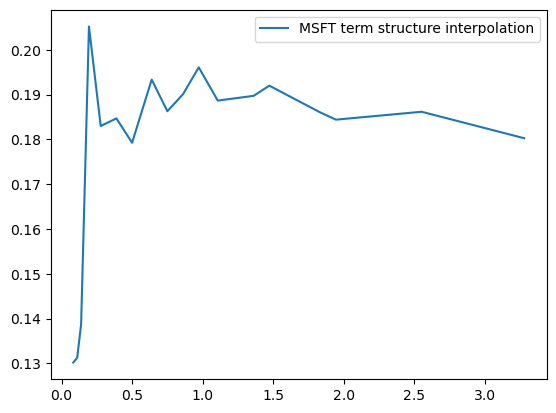

MSFT implied vol =19.45614980562352%


In [138]:
today="2025-09-12"

def bs_call_iv(price, S_spot, K, T, r, q):
    def bs_call(sigma):
        d1=(np.log(S_spot/K)+(r-q+sigma**2/2)*T)/(sigma * np.sqrt(T))
        d2=d1-sigma*np.sqrt(T)
        return S_spot * np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)-price
    try:
        iv = newton(bs_call, x0=0.2, tol=1e-6, maxiter=100) #return the roots of the function bs_call, x0 is an indicative value, and 100 the number of iterations not to exceed
        if iv <= 0:   # résultat aberrant
            return np.nan 
        return iv
    except (RuntimeError, OverflowError):
        return np.nan

########## MSFT ############
msft_options=yf.Ticker("MSFT")
msft_maturities=msft_options.options
iv_data=[]
mat_data=[]

for maturity in msft_maturities:
    chain=msft_options.option_chain(maturity).calls # Get all the calls for that maturity
    call=chain.loc[(chain['strike']==K_MSFT)] # Filter with a strike of 500
    if len(call)>0:
        strike_used=call['strike'].values[0]
        price=call['lastPrice'].values[0]
        if price>0:
            T=(datetime.strptime(maturity, '%Y-%m-%d')- datetime.strptime(today,'%Y-%m-%d')).days/N
            iv=bs_call_iv(price, S_MSFT_spot, strike_used,T,r,q_MSFT)
            iv_data.append(iv)
            mat_data.append(T)


interp_func = interp1d(mat_data, iv_data, kind='linear', fill_value='extrapolate')
sigma_imp_MSFT = interp_func(1.0)

plt.plot(mat_data,interp_func(mat_data),label="MSFT term structure interpolation")
plt.legend()
plt.show()

print('MSFT implied vol ='+str(sigma_imp_MSFT*100)+"%")

The interpolated implied volatility for MSFT for T=1 is calculated at 19.5%, which is notably lower than the historical volatility of 24.5% over the past year. This discrepancy is somewhat unexpected, as implied volatility typically incorporates a risk premium and is often higher than historical volatility due to market expectations of future uncertainty. The difference may suggest that the market anticipates a decrease in volatility over the next year, possibly reflecting a period of stability, or it could indicate limitations in the data or model assumptions, such as the use of a fixed strike of 500 or potential illiquidity in the options used (only 21 options used). 

Now, let's do the same with AAPL : 

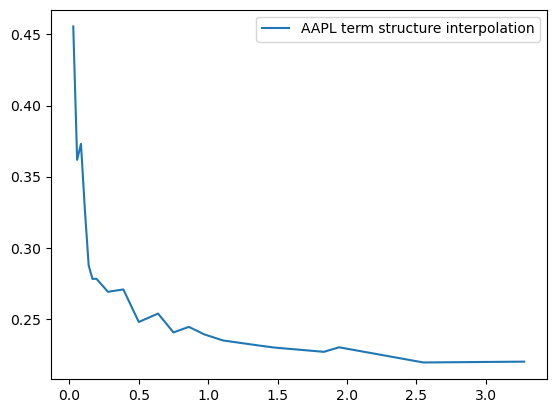

AAPL implied vol =23.818422059423412%


In [124]:
########## AAPL ############
aapl_options=yf.Ticker("AAPL")
aapl_maturities=aapl_options.options
iv_data=[]
mat_data=[]

for maturity in aapl_maturities:
    chain=aapl_options.option_chain(maturity).calls # Get all the calls for that maturity
    call=chain.loc[(chain['strike']==K_AAPL)] # Filter with a strike of 230
    if len(call)>0:
        strike_used=call['strike'].values[0]
        price=call['lastPrice'].values[0]
        if price>0:
            T=(datetime.strptime(maturity, '%Y-%m-%d')- datetime.strptime(today,'%Y-%m-%d')).days/N
            iv=bs_call_iv(price, S_AAPL_spot, strike_used, T, r, q_AAPL)
            iv_data.append(iv)
            mat_data.append(T)


interp_func=interp1d(mat_data, iv_data, kind='linear', fill_value='extrapolate')
sigma_imp_AAPL=interp_func(1.0)

plt.plot(mat_data,interp_func(mat_data),label="AAPL term structure interpolation")
plt.legend()
plt.show()

print('AAPL implied vol ='+str(sigma_imp_AAPL*100)+"%")

The interpolated implied volatility for AAPL for T=1 is 23.7%. As MSFT, the implied volatility is lower than the historical volatility.

### 2.   Construction of our portfolios, and basic delta hedging simulation

For this part, the delta-hedged portfolio is rebalanced on a daily basis

**Implementation of the price of the two correlated underlyings, for $N$ days :**

In [139]:
def S_price_correlated(mu1,mu2,sigma1,sigma2,N,S_spot1,S_spot2,corr):
    S1,S2=[0]*N,[0]*N
    S1[0],S2[0]=S_spot1,S_spot2
    for i in range(1,N):
        z1=np.random.randn()
        z2=np.random.randn()
        eps1=z1
        eps2=corr*z1+np.sqrt(1-corr**2)*z2
        S1[i]=S1[i-1]*np.exp((mu1-0.5*sigma1**2)*1/N+sigma1*np.sqrt(1/N)*eps1)
        S2[i]=S2[i-1]*np.exp((mu2-0.5*sigma2**2)*1/N+sigma2*np.sqrt(1/N)*eps2)
    return S1,S2

**We now compute the $\Delta$ of the portfolio.** Since we have two underlyings, we need to delta hedge our positions on the two assets :

In [153]:
def N_d1(K,r,sigma,N,S,q): # function that returns N(d_1) of an option
    L=[0]*N
    for i in range(N): 
        tau=(N-i)/N
        d1=(np.log(S[i]/K)+(r-q+sigma**2/2)*tau)/(sigma*np.sqrt(tau))
        L[i]=np.exp(-q*tau)*norm.cdf(d1)
    return L

def Delta_Portfolio(w1,w2,w3,S_MSFT,S_AAPL): #function that returns the delta of the position on MSFT and AAPL
    Nd1_MSFT = N_d1(K_MSFT, r, sigma_imp_MSFT, N, S_MSFT, q_MSFT)
    Nd1_AAPL = N_d1(K_AAPL, r, sigma_imp_AAPL, N, S_AAPL, q_AAPL)

    D1=Nd1_MSFT  #Delta of a MSFT call
    D2=[elmt-1 for elmt in Nd1_MSFT]  #Delta of a MSFT put
    D3=Nd1_AAPL  #Delta of a AAPL call
     
    Delta_MSFT=[-D1[i]*w1+w2*D2[i] for i in range(len(N_d1(K_MSFT,r,sigma_imp_MSFT,N,S_MSFT,q_MSFT)))]
    Delta_AAPL=[-D3[i]*w3 for i in range(len(N_d1(K_MSFT,r,sigma_imp_MSFT,N,S_MSFT,q_MSFT)))]
    return (Delta_MSFT,Delta_AAPL)

We use Black-Scholes to compute the **price of a call and a put** : 

In [44]:
def c_price(N,S,sigma,q,K):
    c=[0]*N
    for i in range(N):
        tau=(N-i)/N
        d1=(np.log(S[i]/K)+(r-q+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
        c[i]=S[i]*np.exp(-q*tau)*norm.cdf(d1)-K*np.exp(-r*tau)*norm.cdf(d1-sigma*np.sqrt(tau))
    return c

def p_price(N,S,sigma,q,K):
    p=[0]*N
    for i in range(N):
        tau=(N-i)/N
        d1=(np.log(S[i]/K)+(r-q +0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
        d2=d1-sigma*np.sqrt(tau)
        p[i]=K*np.exp(-r*tau)*norm.cdf(-d2)-S[i]*np.exp(-q*tau)*norm.cdf(-d1)
    return p

To calculate the value of the hedged portfolio, we include the net gains or losses from transactions on the underlying assets required to rebalance it. These are computed and tracked in the cash account. 

The cash account is updated at each step to reflect rebalancing costs:

In [165]:
def cash_account_MSFT(N,c_MSFT,Delta_MSFT,S_MSFT,p_MSFT):
    B=[0]*N
    B[0]=w1*c_MSFT[0]-(-Delta_MSFT[0]*S_MSFT[0])-w2*p_MSFT[0] #initially, we receive w1*c_MSFT[0] from shorting the call, we pay w2*p_MSFT[0] from the puts and we pay -(-Delta_MSFT[0]*S_MSFT[0]) of hedging
    for i in range(1,N):
        B[i]=B[i-1]*(1+r/N)+(Delta_MSFT[i]-Delta_MSFT[i-1])*S_MSFT[i] #previous amount of money grows at the risk-free-rate and we add the new shares needed to hedge the new position
    return B

def cash_account_AAPL(N,c_AAPL,Delta_AAPL,S_AAPL):
    B=[0]*N
    B[0]=-(-Delta_AAPL[0]*S_AAPL[0])+w3*c_AAPL[0]
    for i in range(1,N):
        B[i]=B[i-1]*(1+r/N)+(Delta_AAPL[i]-Delta_AAPL[i-1])*S_AAPL[i]
    return B

Now, we implemente the **valuation of the portfolio** for each day : 

In [166]:
def Portfolio(N,c_MSFT,Delta_MSFT,S_MSFT,p_MSFT,c_AAPL,Delta_AAPL,S_AAPL,B_MSFT,B_AAPL):
    P=[0]*N
    P[0]=-w1*c_MSFT[0]-Delta_MSFT[0]*S_MSFT_spot+w2*p_MSFT[0]-w3*c_AAPL[0]-Delta_AAPL[0]*S_AAPL[0]+B_AAPL[0]+B_MSFT[0] #it actually gives P[0]=0 : we assume the portfolio auto-financed, it doesn't change much not to include the inital position in options
    for i in range(1,N):
        P[i]=-w1*c_MSFT[i]-Delta_MSFT[i]*S_MSFT[i]+w2*p_MSFT[i]-w3*c_AAPL[i]-Delta_AAPL[i]*S_AAPL[i]+B_MSFT[i]+B_AAPL[i]
    return P

#### Let's see what it gives for a single simulation run :  

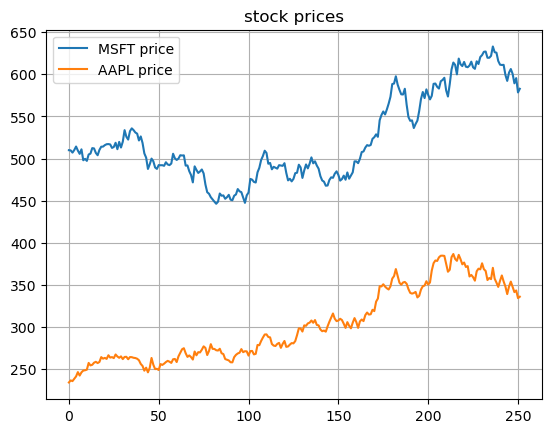

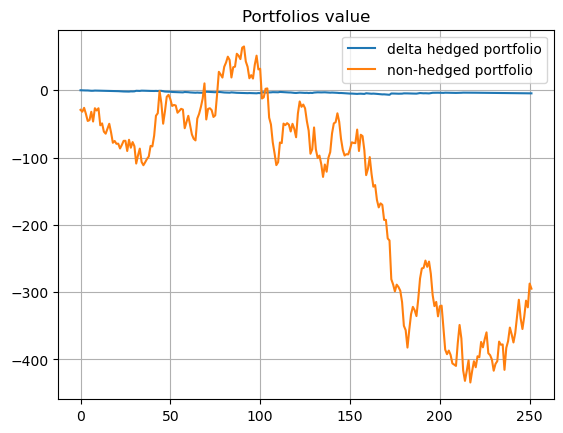

In [191]:
####### Compute the portfolios ######

S_MSFT_corr,S_AAPL_corr=S_price_correlated(mu_MSFT,mu_AAPL,sigma_imp_MSFT,sigma_imp_AAPL,N,S_MSFT_spot,S_AAPL_spot,rho)

D_MSFT,D_AAPL=Delta_Portfolio(w1,w2,w3,S_MSFT_corr,S_AAPL_corr)

call_MSFT=c_price(N,S_MSFT_corr,sigma_imp_MSFT,q_MSFT,K_MSFT)
call_AAPL=c_price(N,S_AAPL_corr,sigma_imp_AAPL,q_AAPL,K_AAPL)
put_MSFT=p_price(N,S_MSFT_corr,sigma_imp_MSFT,q_MSFT,K_MSFT)

cash_MSFT=cash_account_MSFT(N,call_MSFT,D_MSFT,S_MSFT_corr,put_MSFT)
cash_AAPL=cash_account_AAPL(N,call_AAPL,D_AAPL,S_AAPL_corr)

Port_hedged=Portfolio(N,call_MSFT,D_MSFT,S_MSFT_corr,put_MSFT,call_AAPL,D_AAPL,S_AAPL_corr,cash_MSFT,cash_AAPL)
Port_nonhedged=[-w1*call_MSFT[i] + w2*put_MSFT[i] -w3*call_AAPL[i] for i in range(len(call_AAPL))] #To compare, we create a non-hedged portfolio


######### PLOT #####################

def plot_S(S1,S2):
    plt.grid()
    plt.plot(days,S1,label="MSFT price")
    plt.plot(days,S2,label="AAPL price")
    plt.title("stock prices")
    plt.legend()
    plt.show()
    
def plot_test(P1,P2):
    plt.plot(days,P1,label="delta hedged portfolio")
    plt.plot(days,P2,label="non-hedged portfolio")
    plt.title("Portfolios value")
    plt.legend()
    plt.grid()
    plt.show()
    
plot_S(S_MSFT_corr,S_AAPL_corr)
plot_test(Port_hedged,Port_nonhedged)

We can observe that the non-hedged portfolio is highly volatile, and gives uncertain profit, as we could guessed.
$\newline$ On the other hand, the hedged portfolio is closed to be constantly equal to 0. That's indeed what we should expect from a delta-hedged portfolio.

#### Let’s now look at the outcomes of multiple simulations to compute the mean and standard deviation :

In [169]:
def Simu_Monte_Carlo(n):
    PNL_hedge,PNL_nohedge=[0]*n,[0]*n
    for i in range (n):
        S_MSFT,S_AAPL=S_price_correlated(mu_MSFT,mu_AAPL,sigma_imp_MSFT,sigma_imp_AAPL,N,S_MSFT_spot,S_AAPL_spot,rho)
        Delta_MSFT,Delta_AAPL = Delta_Portfolio(w1,w2,w3,S_MSFT,S_AAPL)
        c_MSFT=c_price(N,S_MSFT,sigma_imp_MSFT,q_MSFT,K_MSFT)
        p_MSFT=p_price(N,S_MSFT,sigma_imp_MSFT,q_MSFT,K_MSFT)
        c_AAPL=c_price(N,S_AAPL,sigma_imp_AAPL,q_AAPL,K_AAPL)
        B_MSFT=cash_account_MSFT(N,c_MSFT,Delta_MSFT,S_MSFT,p_MSFT)
        B_AAPL=cash_account_AAPL(N,c_AAPL,Delta_AAPL,S_AAPL)
        
        P_hedged=Portfolio(N,c_MSFT,Delta_MSFT,S_MSFT,p_MSFT,c_AAPL,Delta_AAPL,S_AAPL,B_MSFT,B_AAPL)
        
        P_nonhedged=[-w1*c_MSFT[j] + w2*p_MSFT[j] -w3*c_AAPL[j] for j in range(len(c_AAPL))]
        
        PNL_nohedge[i]=P_nonhedged[N-1]-P_nonhedged[0]
        PNL_hedge[i]=P_hedged[N-1]-P_hedged[0]

    print("Average profit without hedge = "+str(np.mean(PNL_nohedge))+"  standard deviation= "+str(np.std(PNL_nohedge)))
    print("Average profit with hedge = "+str(np.mean(PNL_hedge))+"  standard deviation = "+str(np.std(PNL_hedge)))

In [177]:
Simu_Monte_Carlo(100)

Average profit without hedge = -16.726681786589964  standard deviation= 206.53985367871005
Average profit with hedge = -7.1979740434308095  standard deviation = 4.836868648300288


For example, for $n=50$ , I got the following result : 
$\newline \textit{"Average profit without hedge = -16.726681786589964  standard deviation= 206.53985367871005"}$
$\textit{"Average profit with hedge = -7.1979740434308095  standard deviation = 4.836868648300288"}$
$\newline$ Even though the means seem to be close, we can see that the P&L from the non-hedged-portfolio is highly uncertain.
The P&L from the hedged portfolio is much more certain, and close to zero, but not exactly.
$\newline$ In an ideal Black-Scholes model with continuous delta hedging, the P&L of a perfectly hedged portfolio should be zero, as the strategy replicates the option's value and eliminates directional risk. However, in our discrete Monte Carlo simulation with \( N = 252 \) steps, the P&L is close to 0 but not exactly 0 due to the following reasons:
- Discrete Rebalancing: Hedging occurs at discrete intervals rather than continuously, leading to small errors from unhedged price movements between steps (known as gamma risk).
- Estimation Errors: The deltas and option prices are approximated using historical volatility and discrete calculations, which may deviate slightly from true market values.
- Randomness: Each simulation path is stochastic, and the finite number of simulations ($n = 100$) introduces statistical noise.

These factors cause a small residual P&L, but the hedging significantly reduces volatility compared to the unhedged case.

### 3.  Influence of Delta Hedge Rebalancing Frequency

We have compared the performance of a delta-hedged portfolio versus an unhedged one. However, as we saw, the delta changed with the movement of the underlying, making the hedge dynamical. As the position needs to be rebalanced, we can wonder of the impact of the rebalancing frequencies. 
$\newline$ Let's try to rebalance the portfolio on a 2 days-basis, on a weekly-basis and on a mnothly-basis, and compare those portfolios with the first one.

**Calculation of the portfolio**

In [186]:
def Delta_Portfolio_rebalancing(w1,w2,w3,S_MSFT,S_AAPL,freq):
    Nd1_MSFT = N_d1(K_MSFT, r, sigma_imp_MSFT, N, S_MSFT, q_MSFT)
    Nd1_AAPL = N_d1(K_AAPL, r, sigma_imp_AAPL, N, S_AAPL, q_AAPL)

    D1=Nd1_MSFT  
    D2=[elmt-1 for elmt in Nd1_MSFT]  
    D3=Nd1_AAPL  
    
    Delta_MSFT,Delta_AAPL=[0]*N,[0]*N
    for i in range(N):
        if i%freq==0:
            Delta_MSFT[i],Delta_AAPL[i]=-D1[i]*w1+w2*D2[i],-D3[i]*w3
        else:
            Delta_MSFT[i],Delta_AAPL[i]=Delta_MSFT[i-1],Delta_AAPL[i-1]
    return (Delta_MSFT,Delta_AAPL)

#### 2 days basis ####
D_MSFT_2daysbasis,D_AAPL_2daysbasis=Delta_Portfolio_rebalancing(w1,w2,w3,S_MSFT_corr,S_AAPL_corr,2)

cash_MSFT_2daysbasis=cash_account_MSFT(N,call_MSFT,D_MSFT_2daysbasis,S_MSFT_corr,put_MSFT)
cash_AAPL_2daysbasis=cash_account_AAPL(N,call_AAPL,D_AAPL_2daysbasis,S_AAPL_corr)

Port_hedged_2daysbasis=Portfolio(N,call_MSFT,D_MSFT_2daysbasis,S_MSFT_corr,put_MSFT,call_AAPL,D_AAPL_2daysbasis,S_AAPL_corr,cash_MSFT_2daysbasis,cash_AAPL_2daysbasis)

#### weekly ####

D_MSFT_weekly,D_AAPL_weekly=Delta_Portfolio_rebalancing(w1,w2,w3,S_MSFT_corr,S_AAPL_corr,5)

cash_MSFT_weekly=cash_account_MSFT(N,call_MSFT,D_MSFT_weekly,S_MSFT_corr,put_MSFT)
cash_AAPL_weekly=cash_account_AAPL(N,call_AAPL,D_AAPL_weekly,S_AAPL_corr)

Port_hedged_weekly=Portfolio(N,call_MSFT,D_MSFT_weekly,S_MSFT_corr,put_MSFT,call_AAPL,D_AAPL_weekly,S_AAPL_corr,cash_MSFT_weekly,cash_AAPL_weekly)


#### monthly ####

D_MSFT_monthly,D_AAPL_monthly=Delta_Portfolio_rebalancing(w1,w2,w3,S_MSFT_corr,S_AAPL_corr,21)

cash_MSFT_monthly=cash_account_MSFT(N,call_MSFT,D_MSFT_monthly,S_MSFT_corr,put_MSFT)
cash_AAPL_monthly=cash_account_AAPL(N,call_AAPL,D_AAPL_monthly,S_AAPL_corr)

Port_hedged_monthly=Portfolio(N,call_MSFT,D_MSFT_monthly,S_MSFT_corr,put_MSFT,call_AAPL,D_AAPL_monthly,S_AAPL_corr,cash_MSFT_monthly,cash_AAPL_monthly)


**Let's compare the four portfolios on a single run :**

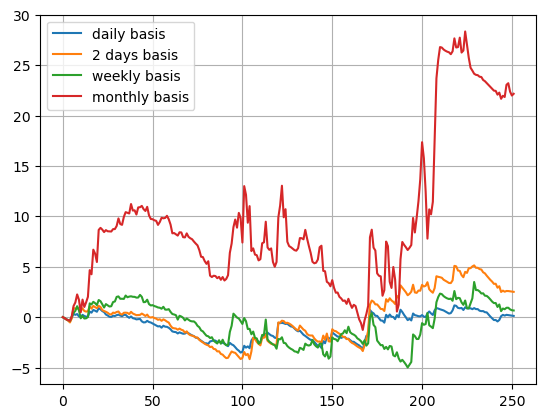

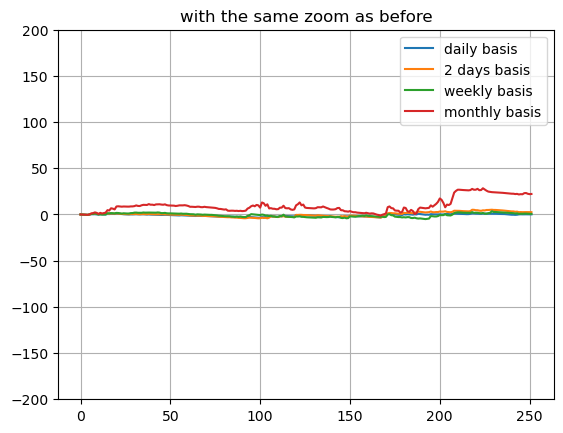

In [190]:
plt.plot(days,Port_hedged,label="daily basis")
plt.plot(days,Port_hedged_2daysbasis,label="2 days basis")
plt.plot(days,Port_hedged_weekly,label="weekly basis")
plt.plot(days,Port_hedged_monthly,label="monthly basis")
plt.legend()
plt.grid()
plt.show()

plt.ylim(-200, 200)
plt.plot(days,Port_hedged,label="daily basis")
plt.plot(days,Port_hedged_2daysbasis,label="2 days basis")
plt.plot(days,Port_hedged_weekly,label="weekly basis")
plt.plot(days,Port_hedged_monthly,label="monthly basis")
plt.title("with the same zoom as before")
plt.legend()
plt.grid()
plt.show()

The graph illustrates the valuation of the hedged portfolios over a 1-year maturity. We observe that the valuation becomes increasingly volatile as the rebalancing frequency decreases. The final value increases, but this should be due this particular simulation. We notice that the graphs are more and more uncertain and follow less and less a perfect $y=0$ straight line. This pattern is expected due to the discrete nature of rebalancing in a real-world simulation, as opposed to the continuous hedging assumed in the Black-Scholes model.
The primary justification for these discrepancies lies in the gamma effect. Delta hedging neutralizes first-order risk but leaves residual exposure to gamma, which is typically positive for options and leads to a hedging error  between rebalancing intervals. 
Additionally, without transaction costs, higher frequencies perform better, as they reduce gamma-induced discrepancies. In practice, costs would favor an optimal balance. This highlights the trade-off between hedging accuracy and operational feasibility in real markets.

**Now, let's run a Monte Carlo simulation to have the means and standard deviations**

In [208]:
def Simu_Monte_Carlo_2(n):
    PNL_hedged_daily,PNL_hedged_2daysbasis,PNL_hedged_weekly,PNL_hedged_monthly=[0]*n,[0]*n,[0]*n,[0]*n
    for i in range (n):
        S_MSFT,S_AAPL=S_price_correlated(mu_MSFT,mu_AAPL,sigma_imp_MSFT,sigma_imp_AAPL,N,S_MSFT_spot,S_AAPL_spot,rho)
        Delta_MSFT,Delta_AAPL = Delta_Portfolio(w1,w2,w3,S_MSFT,S_AAPL)
        c_MSFT=c_price(N,S_MSFT,sigma_imp_MSFT,q_MSFT,K_MSFT)
        p_MSFT=p_price(N,S_MSFT,sigma_imp_MSFT,q_MSFT,K_MSFT)
        c_AAPL=c_price(N,S_AAPL,sigma_imp_AAPL,q_AAPL,K_AAPL)
        B_MSFT=cash_account_MSFT(N,c_MSFT,Delta_MSFT,S_MSFT,p_MSFT)
        B_AAPL=cash_account_AAPL(N,c_AAPL,Delta_AAPL,S_AAPL)
        
        P_hedged=Portfolio(N,c_MSFT,Delta_MSFT,S_MSFT,p_MSFT,c_AAPL,Delta_AAPL,S_AAPL,B_MSFT,B_AAPL)
        
        D_MSFT_2daysbasis,D_AAPL_2daysbasis=Delta_Portfolio_rebalancing(w1,w2,w3,S_MSFT,S_AAPL,2)
        B_MSFT_2daysbasis=cash_account_MSFT(N,c_MSFT,D_MSFT_2daysbasis,S_MSFT,p_MSFT)
        B_AAPL_2daysbasis=cash_account_AAPL(N,c_AAPL,D_AAPL_2daysbasis,S_AAPL)
        Port_hedged_2daysbasis=Portfolio(N,c_MSFT,D_MSFT_2daysbasis,S_MSFT,p_MSFT,c_AAPL,D_AAPL_2daysbasis,S_AAPL,B_MSFT_2daysbasis,B_AAPL_2daysbasis)

        D_MSFT_weekly,D_AAPL_weekly=Delta_Portfolio_rebalancing(w1,w2,w3,S_MSFT,S_AAPL,5)
        B_MSFT_weekly=cash_account_MSFT(N,c_MSFT,D_MSFT_weekly,S_MSFT,p_MSFT)
        B_AAPL_weekly=cash_account_AAPL(N,c_AAPL,D_AAPL_weekly,S_AAPL)
        Port_hedged_weekly=Portfolio(N,c_MSFT,D_MSFT_weekly,S_MSFT,p_MSFT,c_AAPL,D_AAPL_weekly,S_AAPL,B_MSFT_weekly,B_AAPL_weekly)

        D_MSFT_monthly,D_AAPL_monthly=Delta_Portfolio_rebalancing(w1,w2,w3,S_MSFT,S_AAPL,21)
        B_MSFT_monthly=cash_account_MSFT(N,c_MSFT,D_MSFT_monthly,S_MSFT,p_MSFT)
        B_AAPL_monthly=cash_account_AAPL(N,c_AAPL,D_AAPL_monthly,S_AAPL)
        Port_hedged_monthly=Portfolio(N,c_MSFT,D_MSFT_monthly,S_MSFT,p_MSFT,c_AAPL,D_AAPL_monthly,S_AAPL,B_MSFT_monthly,B_AAPL_monthly)

    
        PNL_hedged_daily[i]=P_hedged[N-1]-P_hedged[0]
        PNL_hedged_2daysbasis[i]=Port_hedged_2daysbasis[N-1]-Port_hedged_2daysbasis[0]
        PNL_hedged_weekly[i]=Port_hedged_weekly[N-1]-Port_hedged_weekly[0]
        PNL_hedged_monthly[i]=Port_hedged_monthly[N-1]-Port_hedged_monthly[0]

    print("Average profit_daily= "+str(np.mean(PNL_hedged_daily))+"  standard deviation_daily= "+str(np.std(PNL_hedged_daily)))
    print("Average profit_2daysbasis= "+str(np.mean(PNL_hedged_2daysbasis))+"  standard deviation_2daysbasis= "+str(np.std(PNL_hedged_2daysbasis)))
    print("Average profit_weekly "+str(np.mean(PNL_hedged_weekly))+"  standard deviation_weekly= "+str(np.std(PNL_hedged_weekly)))
    print("Average profit_monthly "+str(np.mean(PNL_hedged_monthly))+"  standard deviation_monthly= "+str(np.std(PNL_hedged_monthly)))
    
   # Moyenne et écart-type des P&L pour chaque fréquence
    frequencies = ['Daily', '2-days', 'Weekly', 'Monthly']
    mean_PNL = [np.mean(PNL_hedged_daily), np.mean(PNL_hedged_2daysbasis),
                np.mean(PNL_hedged_weekly), np.mean(PNL_hedged_monthly)]
    std_PNL = [np.std(PNL_hedged_daily), np.std(PNL_hedged_2daysbasis),
               np.std(PNL_hedged_weekly), np.std(PNL_hedged_monthly)]

    # Plot
    plt.figure(figsize=(8,5))
    plt.errorbar(frequencies, mean_PNL, yerr=std_PNL, fmt='o-', capsize=5)
    plt.xlabel("Rebalancing Frequency")
    plt.ylabel("Portfolio P&L")
    plt.title("Impact of Rebalancing Frequency on Delta-Hedged Portfolio")
    plt.grid(True)
    plt.show()
    
    
    

Average profit_daily= -7.198860220049061  standard deviation_daily= 5.164281889691985
Average profit_2daysbasis= -7.045170403975235  standard deviation_2daysbasis= 6.72427036530113
Average profit_weekly -8.57526236708133  standard deviation_weekly= 9.698817364353463
Average profit_monthly -13.006071632102213  standard deviation_monthly= 20.33985090406608


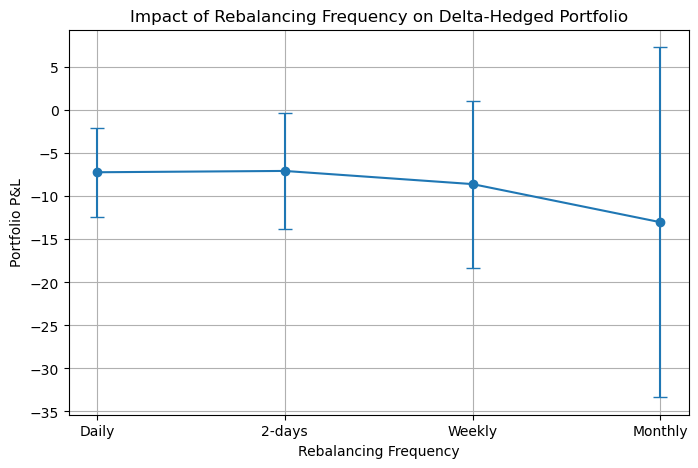

In [209]:
Simu_Monte_Carlo_2(100)

For $n=100$, I got : 
$\newline$ "$\textit{Average profit_daily= -7.198860220049061  standard deviation_daily= 5.164281889691985}$
$\newline$ $\textit{Average profit_2daysbasis= -7.045170403975235  standard deviation_2daysbasis= 6.72427036530113}$
$\newline$ $\textit{Average profit_weekly -8.57526236708133  standard deviation_weekly= 9.698817364353463}$
$\newline$ $\textit{Average profit_monthly -13.006071632102213  standard deviation_monthly= 20.33985090406608}$"

The average profit shows a consistent trend of increasing losses with decreasing frequency: daily rebalancing yields a loss of -7.19 with a standard deviation of 5.16, 2-day rebalancing results in a loss of -7.04 (std 6.72), weekly rebalancing at -8.57 (std 9.69), and monthly rebalancing shows the largest loss at -13 with a standard deviation of 20.33. This pattern aligns with expectations, as less frequent rebalancing amplifies gamma-related hedging errors due to larger price movements between adjustments.